# Variational Basis State Encoder (Time Dependent)

## 1 Background
This tutorial is for the time evolution of variational basis state encoder (VBE). Here, spin-boson model is taken as an example. As shall be presented below, the key is to calculate $\dot{\theta}_j$ and $\dot{C}[l]^*$. The algorithm realization are presented in section 2. For more theoretical derivations, see https://doi.org/10.1103/PhysRevResearch.5.023046.

## 2 Algorithm Realization

### 2.1 Imports

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from opt_einsum import contract
import tensorcircuit as tc

from tencirchem import set_backend, Op, Mpo, Model, OpSum
from tencirchem.dynamic import get_ansatz, get_deriv, get_jacobian_func, qubit_encode_basis, sbm
from tencirchem.applications.vbe_lib import get_psi_indices, get_contracted_mpo, get_contract_args

### 2.2 Initialize
In this tutorial, we study the time evolution of the following spin-boson model:

$$\hat{H}=\frac{\epsilon}{2} \hat{\sigma}_z + \Delta\hat{\sigma}_x + \sum_j g_j \omega_j \hat{\sigma}_z (\hat{b}^\dagger_j + \hat{b}_j)
+ \sum_j \omega_j \hat{b}^\dagger_j \hat{b}_j$$

Here, `epsilon`, `delta`, `omega_list` and `g_list` correspond to $\epsilon$, $\Delta$, $\omega_j$ and $g_j$ in the Hamiltonian, respectively.
In this section, the parameters are defined and the circuit is initialized. The schematic diagram of the circuit is plotted in Fig. 1, where blue square corresponds to qubit representing spin and green circles correspond to qubits representing vibrations. 
![fig1](../statics/vbe_td_Fig1.svg)
Fig. 1 Schematic diagram of the circuit.

In [2]:
set_backend("jax")

epsilon = 0
delta = 1
omega_list = [0.5, 1]
g_list = [0.25, 1]

nmode = len(omega_list)  # number of phonon modes
# make sure correct input
assert nmode == len(g_list)

# two qubit for each mode
n_qubit_per_mode = 2
nbas_v = 1 << n_qubit_per_mode

# -1 for electron dof, natural numbers for phonon dof
dof_nature = np.array([-1] + [0] * n_qubit_per_mode + [1] * n_qubit_per_mode)
b_dof_pidx = np.array([1, 2])  # index of basis that need VBE

n_dof = len(dof_nature)
psi_shape2 = [2] * n_dof

psi_idx_top, psi_idx_bottom, b_dof_vidx = get_psi_indices(dof_nature, b_dof_pidx, n_qubit_per_mode)
print(
    "psi_index_top: ",
    psi_idx_bottom,
    "\npsi_index_bottom: ",
    psi_idx_bottom,
    "\nb_dof_vidx: ",
    b_dof_vidx,
    "\npsi_shape2: ",
    psi_shape2,
)


# spin boson model has been define in tencirchem.dynamic.model
def get_model(epsilon, delta, nmode, omega_list, g_list, nlevels):
    ham_terms = sbm.get_ham_terms(epsilon, delta, nmode, omega_list, g_list)
    basis = sbm.get_basis(omega_list, nlevels)
    return Model(basis, ham_terms)


nbas = 16  # number of phonon levels (basis)

b_shape = tuple([2] * n_qubit_per_mode + [nbas])

assert len(omega_list) == nmode
assert len(g_list) == nmode
model = get_model(epsilon, delta, nmode, omega_list, g_list, [nbas] * nmode)

h_mpo = Mpo(model)

# generate the quantum circuit with defined qubits
circuit = tc.Circuit(1 + nmode * n_qubit_per_mode)
psi0 = circuit.state()
n_layers = 3  # layers of ansatz

2023-08-08 16:12:43.927000: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


psi_index_top:  ['p-0-bottom', 'v-1-0-bottom', 'v-1-1-bottom', 'v-2-0-bottom', 'v-2-1-bottom'] 
psi_index_bottom:  ['p-0-bottom', 'v-1-0-bottom', 'v-1-1-bottom', 'v-2-0-bottom', 'v-2-1-bottom'] 
b_dof_vidx:  [array([1, 2]), array([3, 4])] 
psi_shape2:  [2, 2, 2, 2, 2]


### 2.3 Get variational Hamiltonian ansatz terms
In this section, we will generate variational hamiltonian ansatz terms. The following ansatz is adopted:

$$\ket{\phi} = \prod_n e^{i \theta_n \hat {h}_{a_n}} \ket{\phi_0}$$

if

$$\hat{H}=\sum_a J_a \hat{h}_a$$

Note that the phonon operators have been transformed to qubit operators based on Gray Encoding.

In [3]:
def get_vha_terms():
    basis = sbm.get_basis(omega_list, [nbas_v] * nmode)
    spin_basis = qubit_encode_basis(basis, "gray")

    spin_ham_terms = OpSum([Op("X", ["spin"], 1.0)])
    for i in range(nmode):
        complete_list = []
        for j in range(n_qubit_per_mode):
            complete = OpSum()
            dof = (f"v{i}", f"TCCQUBIT-{j}")
            for symbol in "IXYZ":
                complete += Op(symbol, dof)
            complete_list.append(complete)
        complete_real = complete_list[0]
        for c in complete_list[1:]:
            complete_real = complete_real * c
        spin_ham_terms.extend(complete_real)
        spin_ham_terms.extend(Op("Z", "spin") * complete_real)
    spin_ham_terms = OpSum([op.squeeze_identity() for op in spin_ham_terms.simplify() if not op.is_identity]).simplify()
    return spin_ham_terms, spin_basis


spin_ham_terms, spin_basis = get_vha_terms()

print(spin_basis)
for i in range(len(spin_ham_terms)):
    print(spin_ham_terms[i])


theta0 = np.zeros(n_layers * len(spin_ham_terms), dtype=np.float64)
ansatz = get_ansatz(spin_ham_terms, spin_basis, n_layers, psi0)
jacobian_func = get_jacobian_func(ansatz)

[BasisHalfSpin(dof: spin, nbas: 2), BasisHalfSpin(dof: ('v0', 'TCCQUBIT-0'), nbas: 2), BasisHalfSpin(dof: ('v0', 'TCCQUBIT-1'), nbas: 2), BasisHalfSpin(dof: ('v1', 'TCCQUBIT-0'), nbas: 2), BasisHalfSpin(dof: ('v1', 'TCCQUBIT-1'), nbas: 2)]
Op('X', ['spin'], 1.0)
Op('X', [('v0', 'TCCQUBIT-1')], 1.0)
Op('Y', [('v0', 'TCCQUBIT-1')], 1.0)
Op('Z', [('v0', 'TCCQUBIT-1')], 1.0)
Op('X', [('v0', 'TCCQUBIT-0')], 1.0)
Op('X X', [('v0', 'TCCQUBIT-0'), ('v0', 'TCCQUBIT-1')], 1.0)
Op('X Y', [('v0', 'TCCQUBIT-0'), ('v0', 'TCCQUBIT-1')], 1.0)
Op('X Z', [('v0', 'TCCQUBIT-0'), ('v0', 'TCCQUBIT-1')], 1.0)
Op('Y', [('v0', 'TCCQUBIT-0')], 1.0)
Op('Y X', [('v0', 'TCCQUBIT-0'), ('v0', 'TCCQUBIT-1')], 1.0)
Op('Y Y', [('v0', 'TCCQUBIT-0'), ('v0', 'TCCQUBIT-1')], 1.0)
Op('Y Z', [('v0', 'TCCQUBIT-0'), ('v0', 'TCCQUBIT-1')], 1.0)
Op('Z', [('v0', 'TCCQUBIT-0')], 1.0)
Op('Z X', [('v0', 'TCCQUBIT-0'), ('v0', 'TCCQUBIT-1')], 1.0)
Op('Z Y', [('v0', 'TCCQUBIT-0'), ('v0', 'TCCQUBIT-1')], 1.0)
Op('Z Z', [('v0', 'TCCQUBIT

### 2.4 Time Evolution
This sections defines the function involved in time evolution. The derivations $\dot{\theta}_j$ are calculated by following equation:

$$\sum_j \textrm{Re} \frac{\partial \bra{\phi}}{\partial \theta_k} \frac{\partial \ket{\phi}}{\partial \theta_j}\dot{\theta}_j = 
\textrm{Im} \frac{\partial \bra{\phi}}{\partial \theta_k} \hat {H}_1$$

where

$$\hat{H}_1=\prod_{l}\hat{B}[l] \hat{H} \prod_{l}\hat{B}[l]^\dagger$$

, and $\frac{\partial \ket{\phi}}{\partial \theta_j}$ is calculated via `theta_deriv`.
The time derivations of $B[l]$ are calculated by following equations:

$$i\rho[l]\dot{B}[l]^* = (1-\hat{P}[l])\bra{\phi}\tilde{H}'[l]\ket{\phi}$$
$$\dot{B}[l]^* = -i \rho[l]^{-1}(1-\hat{P}[l])\bra{\phi}\tilde{H}'[l]\ket{\phi}$$

where

$$\tilde{H}'=\left( \prod_{k\neq l}\hat{B}[l] \hat{H} \prod_{k\neq l}\hat{B}[k]^\dagger \right) \hat{B}[l]^\dagger$$

the projection operator

$$\hat{P}[l]=\hat{B}[l]^\dagger\hat{B}[l]$$

and the reduced density matrix

$$\rho[l]_{nn'}=\textrm{Tr} \left[ \bra{\phi}\ket{n}_l \bra{n'}_l \ket{\phi} \right ]$$

An example that illustrates the function in detail is also presented below.
![fig2](../statics/vbe_td_Fig2.svg)
Fig. 2 Graphic illustration of (a) $\rho[l]$, (b) $P[l]$, (c) $\bra\phi\tilde{H}'[l]\ket\phi$

In [4]:
def deriv_fun(t, theta_and_b):
    # split \thera and b to independent arrays
    theta = theta_and_b[: len(theta0)]
    psi = ansatz(theta)
    b_array = theta_and_b[len(theta0) :].reshape(nmode, nbas_v, nbas)

    # get contracted H
    h_contracted = get_contracted_mpo(h_mpo, b_array, n_qubit_per_mode, b_dof_pidx, psi_idx_top + psi_idx_bottom)
    # get the derivation of \theta
    theta_deriv = get_deriv(ansatz, jacobian_func, theta, h_contracted)

    psi = psi.reshape(psi_shape2)
    b_deriv_list = []
    for i in range(nmode):
        b = b_array[i]
        # calculate rho
        indices_base = [("contract", ii) for ii in range(n_dof)]
        psi_top_indices = indices_base.copy()
        psi_bottom_indices = indices_base.copy()
        for j in b_dof_vidx[i]:
            psi_top_indices[j] = ("top", j)
            psi_bottom_indices[j] = ("bottom", j)
        out_indices = [("top", j) for j in b_dof_vidx[i]] + [("bottom", j) for j in b_dof_vidx[i]]
        args = [psi.conj(), psi_top_indices, psi, psi_bottom_indices, out_indices]
        rho = contract(*args).reshape(1 << n_qubit_per_mode, 1 << n_qubit_per_mode)

        from scipy.linalg import pinv

        rho += np.eye(len(rho)) * 1e-5
        rho_inv = pinv(rho)

        b = b.reshape(nbas_v, nbas)
        # calculate projector
        proj = b.conj().T @ b

        # derivative
        args = get_contract_args(psi, h_mpo, b_array, i, n_qubit_per_mode, psi_idx_top, psi_idx_bottom, b_dof_pidx)
        k = b_dof_pidx[i]
        args.append(b_array[i].reshape(b_shape))
        args.append([f"v-{k}-{l}-bottom" for l in range(n_qubit_per_mode)] + [f"p-{k}-bottom"])
        # output indices
        args.append([f"v-{k}-{l}-top" for l in range(n_qubit_per_mode)] + [f"p-{k}-top", "mpo-0", f"mpo-{len(h_mpo)}"])

        # take transpose to be compatible with previous code
        b_deriv = contract(*args).squeeze().reshape(nbas_v, nbas).T
        b_deriv = np.einsum("bf, bg -> fg", b_deriv, np.eye(nbas) - proj)
        b_deriv = -1j * np.einsum("fg, fh -> hg", b_deriv, rho_inv.T)
        b_deriv_list.append(b_deriv)
    return np.concatenate([theta_deriv, np.array(b_deriv_list).ravel()])

Let's illustrate the code in detail.
Code that calculates $\rho[l]$ (see Fig. 2(a))

In [5]:
# split \thera and b to independent arrays

b_list = []
for _ in range(nmode):
    b = np.eye(nbas)[:nbas_v]  # nbas_v * nbas
    b_list.append(b)
theta_and_b = np.concatenate([theta0, np.array(b_list).ravel()]).astype(complex)

theta = theta_and_b[: len(theta0)]
psi = ansatz(theta)
b_array = theta_and_b[len(theta0) :].reshape(nmode, nbas_v, nbas)

# get contracted H
h_contracted = get_contracted_mpo(h_mpo, b_array, n_qubit_per_mode, b_dof_pidx, psi_idx_top + psi_idx_bottom)
# get the derivation of \theta
theta_deriv = get_deriv(ansatz, jacobian_func, theta, h_contracted)

psi = psi.reshape(psi_shape2)
b_deriv_list = []
i = 0
print("mode ", i)
b = b_array[i]

# calculate rho[l]
indices_base = [("contract", ii) for ii in range(n_dof)]
psi_top_indices = indices_base.copy()
psi_bottom_indices = indices_base.copy()
for j in b_dof_vidx[i]:
    psi_top_indices[j] = ("top", j)
    psi_bottom_indices[j] = ("bottom", j)
out_indices = [("top", j) for j in b_dof_vidx[i]] + [("bottom", j) for j in b_dof_vidx[i]]
print("out_indices: ", out_indices)
args = [psi.conj(), psi_top_indices, psi, psi_bottom_indices, out_indices]
print("args: \n", args)
rho = contract(*args).reshape(1 << n_qubit_per_mode, 1 << n_qubit_per_mode)
print("rho: \n", rho)

from scipy.linalg import pinv

rho += np.eye(len(rho)) * 1e-5
rho_inv = pinv(rho)

mode  0
out_indices:  [('top', 1), ('top', 2), ('bottom', 1), ('bottom', 2)]
args: 
 [DeviceArray([[[[[1.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]],

               [[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]]],


              [[[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]],

               [[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]]]],



             [[[[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]],

               [[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]]],


              [[[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]],

               [[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]]]]], dtype=complex128), [('contract', 0), ('top', 1), ('top', 2), ('contract', 3), ('contract', 4)], DeviceArray([[[[[1.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j]],

               [[0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j]]],


              [[[0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j]],

               [[0.+0.j, 0.+0.j],
  

Code that calculates $\hat{P}[l]$, (see Fig. 2(b))

In [6]:
b = b.reshape(nbas_v, nbas)
# calculate projector P[l]
proj = b.conj().T @ b
print("proj: ", proj)

proj:  [[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
  0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j

Code that calculates $\bra{\phi}\tilde{H}'[l]\ket{\phi}$ (see Fig. 2(c))

In [7]:
# derivative
args = get_contract_args(psi, h_mpo, b_array, i, n_qubit_per_mode, psi_idx_top, psi_idx_bottom, b_dof_pidx)
k = b_dof_pidx[i]
args.append(b_array[i].reshape(b_shape))
args.append([f"v-{k}-{l}-bottom" for l in range(n_qubit_per_mode)] + [f"p-{k}-bottom"])
# output indices
args.append([f"v-{k}-{l}-top" for l in range(n_qubit_per_mode)] + [f"p-{k}-top", "mpo-0", f"mpo-{len(h_mpo)}"])
print("args in derivative: \n", args)

# take transpose to be compatible with previous code
b_deriv = contract(*args).squeeze().reshape(nbas_v, nbas).T

args in derivative: 
 [DeviceArray([[[[[1.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]],

               [[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]]],


              [[[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]],

               [[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]]]],



             [[[[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]],

               [[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]]],


              [[[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]],

               [[0.-0.j, 0.-0.j],
                [0.-0.j, 0.-0.j]]]]], dtype=complex128), ['p-0-top', 'v-1-0-top', 'v-1-1-top', 'v-2-0-top', 'v-2-1-top'], DeviceArray([[[[[1.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j]],

               [[0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j]]],


              [[[0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j]],

               [[0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j]]]],



             [[[[0.+0.j, 0.+0.j],
   

Contract tensors and calculate $\dot{B}[l]^*$

In [8]:
b_deriv = np.einsum("bf, bg -> fg", b_deriv, np.eye(nbas) - proj)
b_deriv = -1j * np.einsum("fg, fh -> hg", b_deriv, rho_inv.T)
b_deriv_list.append(b_deriv)

## 2.5 Main Structure of the Function
This is the main stucture of the code. We set parameters for time evolution and initialize the system. Then, we update `theta_and_b` in time evolution and calcutate $\langle \sigma_z \rangle$ `z` and $\langle \sigma_x \rangle$ `x` step by step as the time evolves.

In [9]:
theta0 = np.zeros(n_layers * len(spin_ham_terms), dtype=np.float64)
ansatz = get_ansatz(spin_ham_terms, spin_basis, n_layers, psi0)
jacobian_func = get_jacobian_func(ansatz)

b_list = []
for _ in range(nmode):
    b = np.eye(nbas)[:nbas_v]  # nbas_v * nbas
    b_list.append(b)
theta_and_b = np.concatenate([theta0, np.array(b_list).ravel()]).astype(complex)
z_list = [1]
x_list = [0]

tau = 0.1
steps = 100

dummy_model = get_model(epsilon, delta, nmode, omega_list, g_list, [nbas_v] * nmode)
z_op = Mpo(dummy_model, Op("Z", "spin", factor=1)).todense()
x_op = Mpo(dummy_model, Op("X", "spin", factor=1)).todense()

for n in range(steps):
    print(n, float(z_list[-1]))
    # update `theta_and_b`
    sol = solve_ivp(deriv_fun, [n * tau, (n + 1) * tau], theta_and_b)
    theta_and_b = sol.y[:, -1]
    theta = theta_and_b[: len(theta0)]
    psi = ansatz(theta)
    z = psi.conj().T @ (z_op @ psi)
    x = psi.conj().T @ (x_op @ psi)
    z_list.append(z.real)
    x_list.append(x.real)

0 1.0
1 0.9801368820199942
2 0.9221622297057478
3 0.8307164281767181
4 0.712902625694087
5 0.5774908043700016
6 0.4340489975856556
7 0.29215043357543824
8 0.1607516949764221
9 0.04771089791814444
10 -0.040502642430565255
11 -0.09904787191380995
12 -0.12493534752914795
13 -0.11727456640490394
14 -0.07753204265425653
15 -0.009732009482324864
16 0.0795128404043315
17 0.18126828150880098
18 0.2849420221890886
19 0.37936481084384754
20 0.454192768911805
21 0.5014051186981502
22 0.5165776398039041
23 0.49960262655096854
24 0.454624729908236
25 0.38915769753158064
26 0.31259780970942813
27 0.2345813095925135
28 0.1636633691524335
29 0.10653226239863313
30 0.06766729976756988
31 0.04926876472593326
32 0.05139921686178229
33 0.07232882932406118
34 0.10899831508240451
35 0.15745403958628454
36 0.21315107699434557
37 0.27112011043252915
38 0.3261026901074539
39 0.3728086768061548
40 0.40637666288671287
41 0.4229683862535386
42 0.42032486089352117
43 0.3981218276511652
44 0.358045462603464
45 0.30

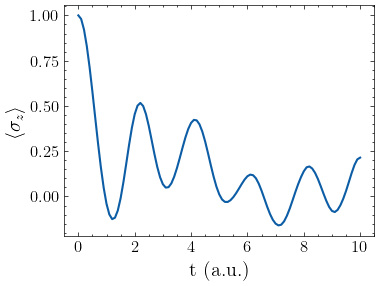

In [12]:
# plot the outcome
from matplotlib import pyplot as plt
import mpl_config

plt.plot(tau * np.arange(101), np.array(z_list))
plt.xlabel("t (a.u.)")
plt.ylabel(r"$\langle \sigma_z \rangle$")
plt.show()